# DAT-500 Project
This notebook is the final project
Project description: Create a machine learning algorithm capable of training a big dtaset of parquet files containing cryptocurrency history from Binance, save the models for later usage and evaluation.

### Fewer settings to be considered:
On remote server check HADOOP_HOME environment variable is properly configured
default hadoop host is hdfs://master:9000
core-site.xml and look for xml element fs.defaultFS
#### List of hadoop remote data files directories:

<font color="Green">Files</font>

- /Data/Abcnews-date-text.csv
- /Data/Binance.csv
- /Data/CoinMarketCap.csv
- /Data/QuandlData.csv
- /Data/cointelegraph_news1-1000_content.csv
- /Data/cointelegraph_news1-1000_head.csv

<font color="Green">Directories </font>

- /Data/Binance_Parquet
- /Data/Binance_Parquet/ADA-BNB.parquet
- /Data/Binance_Parquet/ADA-BTC.parquet
- /Data/Binance_Parquet/ADA-BUSD.parquet


etc/

In [34]:
import os
os.environ["HADOOP_HOME"]

'/usr/local/hadoop'

In [35]:
!cat /usr/local/hadoop/etc/hadoop/core-site.xml

<?xml version="1.0" encoding="UTF-8"?>
<?xml-stylesheet type="text/xsl" href="configuration.xsl"?>
<!--
  Licensed under the Apache License, Version 2.0 (the "License");
  you may not use this file except in compliance with the License.
  You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

  Unless required by applicable law or agreed to in writing, software
  distributed under the License is distributed on an "AS IS" BASIS,
  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
  See the License for the specific language governing permissions and
  limitations under the License. See accompanying LICENSE file.
-->

<!-- Put site-specific property overrides in this file. -->

<configuration>
  <property>
    <name>fs.default.name</name>
    <value>hdfs://master:9000</value>
  </property>
  <property>
    <name>hadoop.proxyuser.ubuntu.hosts</name>
    <value>*</value>
  </property>
  <property>
    <name>hadoop.proxyuser.ubuntu.gro

In [36]:
!pip3.8 install pyarrow
!pip3.8 install hdfs
!pip3.8 install tqdm
!pip3.8 install sklearn
!pip3.8 install matplotlib
!pip3.8 install sparkflow

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [37]:
!ls -ltr /home/ubuntu/

!ls /home/ubuntu/.hdfscli.cfg

!hadoop fs -ls /Data
!hadoop fs -ls /Data/Binance_Parquet

total 460
drwxrwxr-x 3 ubuntu ubuntu   4096 Mar 27 16:07 pkg
drwxr-xr-x 2 ubuntu ubuntu   4096 Apr 10 19:03 dis_materials
-rw-rw-r-- 1 ubuntu ubuntu    225 Apr 11 20:13 spark-yarn.py
drwxrwxr-x 9 ubuntu ubuntu   4096 Apr 12 10:46 python-spark-tutorial
drwxrwxr-x 3 ubuntu ubuntu  36864 Apr 12 11:14 Project_Dataset
-rwxrwxr-x 1 ubuntu ubuntu    143 Apr 19 06:37 jn.sh
drwxrwxr-x 4 ubuntu ubuntu   4096 Apr 19 10:11 notebooks
drwxrwxr-x 7 ubuntu ubuntu   4096 Apr 19 23:35 Tmp
-rw-rw-r-- 1 ubuntu ubuntu  96460 Apr 20 03:12 hs_err_pid21359.log
-rw-rw-r-- 1 ubuntu ubuntu 303275 Apr 20 03:12 replay_pid21359.log
/home/ubuntu/.hdfscli.cfg
ls: Call From master/192.168.13.172 to master:9000 failed on connection exception: java.net.ConnectException: Connection refused; For more details see:  http://wiki.apache.org/hadoop/ConnectionRefused
ls: Call From master/192.168.13.172 to master:9000 failed on connection exception: java.net.ConnectException: Connection refused; For more details see:  http://wik

In [1]:
import os
import tqdm
import pandas as pd
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkFiles
import pyarrow as pa
import pyarrow.parquet as pq

Configure verbosity level for Tensorflow fitting models:


Level | Level for Humans | Level Description                  
 -------|------------------|------------------------------------ 
  0     | DEBUG            | [Default] Print all messages       
  1     | INFO             | Filter out INFO messages           
  2     | WARNING          | Filter out INFO & WARNING messages 
  3     | ERROR            | Filter out all messages 

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}

In [3]:
#set the hadoop hostname to read files and dir
hdp_master = 'hdfs://master:9000'
parquet_dir = '/Data/Binance_Parquet'
#.master('yarn') \
session = SparkSession.builder \
    .appName('DAT500-CRYPTO1') \
    .getOrCreate()


In [4]:
session.conf.get("spark.sql.parquet.compression.codec")
#session.conf.set("spark.sql.parquet.compression.codec","uncompressed")

'snappy'

In [5]:
#session.stop()
#sc = pyspark.SparkContext()
session.sparkContext

<SparkContext master=local[*] appName=DAT500-CRYPTO1>

In [6]:
from hdfs import Config
client = Config().get_client('dev')
parquet_files = client.list(parquet_dir)
parquet_files = [x for x in parquet_files if '.parquet' in x]

In [2]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

import crypto_utils as cu
from crypto_params import *

def try_create_dir(path):
    if not os.path.isdir(path):
        os.mkdir(path)

def try_create_dirs(paths):
    for path in paths:
        try_create_dir(path)

def create_tensorboard(model_name:str):
    checkpoint = ModelCheckpoint(os.path.join("results", model_name), save_weights_only=True, save_best_only=True, verbose=1)
    tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
    return checkpoint, tensorboard


try_create_dirs( (RESULTS_PATH, LOG_PATH, DATA_PATH) )

NameError: name 'os' is not defined

In [7]:
parquet_files[0:5]

['ADA-BNB.parquet',
 'ADA-BTC.parquet',
 'ADA-BUSD.parquet',
 'ADA-ETH.parquet',
 'ADA-PAX.parquet']

In [8]:
%load_ext autoreload
%autoreload 2

In [9]:
%reload_ext autoreload

In [12]:
def train_models(epochs, pfiles):
    models = []
    for parquet_file in tqdm.tqdm(pfiles):
        currency = os.path.splitext(parquet_file)[0]
        df = pq.read_table(f"{hdp_master}/Data/Binance_Parquet/{parquet_file}")
        df = df.to_pandas()
        data = cu.load_data(currency,df,'hour', N_STEPS, window_offset=WINDOW_OFFSET, test_size=TEST_SIZE, feature_cols=FEATURE_COLS,log =False)

        model = cu.create_model(N_STEPS, loss=LOSS, units=N_UNITS, cell=CELL, n_layers=N_LAYERS,dropout=DROPOUT, optimizer=OPTIMIZER)
        checkpoint, tensorboard = create_tensorboard(currency)
        trained_model = model.fit(data["X_train"], data["y_train"],
                            batch_size=BATCH_SIZE,
                            epochs=epochs,
                            validation_data=(data["X_test"], data["y_test"]),
                            callbacks=[checkpoint, tensorboard],
                            verbose=3)

        #json_model = trained_model.model.to_json()
        #cu.save_model(trained_model.model,data, RESULTS_PATH,currency)
        #df_model = spark.read.json(session.parallelize([json_model]))

        model_dict = {'currency':currency,'data':data,'model':trained_model.model}
        models.append(model_dict)
    return models

In [ ]:
EPOCHS = 10 #300    
models2 =train_models(2, parquet_files[0:50])

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/2

Epoch 00001: val_loss improved from inf to 0.00156, saving model to results/ADA-BNB
Epoch 2/2


  2%|▏         | 1/50 [00:54<44:52, 54.95s/it]


Epoch 00002: val_loss did not improve from 0.00156
Epoch 1/2

Epoch 00001: val_loss improved from inf to 0.00662, saving model to results/ADA-BTC
Epoch 2/2


  4%|▍         | 2/50 [01:46<43:04, 53.84s/it]


Epoch 00002: val_loss improved from 0.00662 to 0.00217, saving model to results/ADA-BTC
Epoch 1/2

Epoch 00001: val_loss improved from inf to 0.02242, saving model to results/ADA-BUSD
Epoch 2/2


  6%|▌         | 3/50 [02:02<33:16, 42.49s/it]


Epoch 00002: val_loss did not improve from 0.02242
Epoch 1/2

Epoch 00001: val_loss improved from inf to 0.00283, saving model to results/ADA-ETH
Epoch 2/2

Epoch 00002: val_loss did not improve from 0.00283


  8%|▊         | 4/50 [04:28<56:33, 73.76s/it]

Epoch 1/2

Epoch 00001: val_loss improved from inf to 0.00889, saving model to results/ADA-PAX
Epoch 2/2


 10%|█         | 5/50 [05:21<50:37, 67.51s/it]


Epoch 00002: val_loss improved from 0.00889 to 0.00661, saving model to results/ADA-PAX
Epoch 1/2

Epoch 00001: val_loss improved from inf to 0.00644, saving model to results/ADA-TUSD
Epoch 2/2


 12%|█▏        | 6/50 [06:30<49:48, 67.92s/it]


Epoch 00002: val_loss did not improve from 0.00644
Epoch 1/2

Epoch 00001: val_loss improved from inf to 0.00921, saving model to results/ADA-USDC
Epoch 2/2


 14%|█▍        | 7/50 [07:00<40:29, 56.50s/it]


Epoch 00002: val_loss did not improve from 0.00921
Epoch 1/2

Epoch 00001: val_loss improved from inf to 0.00173, saving model to results/ADA-USDT
Epoch 2/2


 16%|█▌        | 8/50 [07:43<36:45, 52.51s/it]


Epoch 00002: val_loss did not improve from 0.00173
Epoch 1/2

Epoch 00001: val_loss improved from inf to 0.00240, saving model to results/ADX-BNB
Epoch 2/2


 18%|█▊        | 9/50 [08:33<35:17, 51.65s/it]


Epoch 00002: val_loss improved from 0.00240 to 0.00126, saving model to results/ADX-BNB
Epoch 1/2

Epoch 00001: val_loss improved from inf to 0.00197, saving model to results/ADX-BTC
Epoch 2/2


 20%|██        | 10/50 [09:28<35:09, 52.73s/it]


Epoch 00002: val_loss did not improve from 0.00197
Epoch 1/2

Epoch 00001: val_loss improved from inf to 0.00750, saving model to results/ADX-ETH
Epoch 2/2


 22%|██▏       | 11/50 [10:22<34:29, 53.07s/it]


Epoch 00002: val_loss improved from 0.00750 to 0.00482, saving model to results/ADX-ETH
Epoch 1/2

Epoch 00001: val_loss improved from inf to 0.00269, saving model to results/AE-BNB
Epoch 2/2


 24%|██▍       | 12/50 [11:11<32:53, 51.92s/it]


Epoch 00002: val_loss improved from 0.00269 to 0.00198, saving model to results/AE-BNB
Epoch 1/2

Epoch 00001: val_loss improved from inf to 0.00196, saving model to results/AE-BTC
Epoch 2/2


 26%|██▌       | 13/50 [12:00<31:21, 50.86s/it]


Epoch 00002: val_loss improved from 0.00196 to 0.00171, saving model to results/AE-BTC
Epoch 1/2

Epoch 00001: val_loss improved from inf to 0.00314, saving model to results/AE-ETH
Epoch 2/2


 28%|██▊       | 14/50 [12:50<30:26, 50.75s/it]


Epoch 00002: val_loss improved from 0.00314 to 0.00260, saving model to results/AE-ETH
Epoch 1/2

Epoch 00001: val_loss improved from inf to 0.00261, saving model to results/AGI-BNB
Epoch 2/2

Epoch 00002: val_loss improved from 0.00261 to 0.00145, saving model to results/AGI-BNB


 30%|███       | 15/50 [13:35<28:36, 49.05s/it]

Epoch 1/2

Epoch 00001: val_loss improved from inf to 0.00255, saving model to results/AGI-BTC
Epoch 2/2


 32%|███▏      | 16/50 [14:19<26:51, 47.39s/it]


Epoch 00002: val_loss did not improve from 0.00255
Epoch 1/2

Epoch 00001: val_loss improved from inf to 0.00627, saving model to results/AGI-ETH
Epoch 2/2


 34%|███▍      | 17/50 [15:02<25:19, 46.03s/it]


Epoch 00002: val_loss did not improve from 0.00627
Epoch 1/2

Epoch 00001: val_loss improved from inf to 0.00086, saving model to results/AION-BNB
Epoch 2/2


 36%|███▌      | 18/50 [15:53<25:22, 47.58s/it]


Epoch 00002: val_loss did not improve from 0.00086
Epoch 1/2

Epoch 00001: val_loss improved from inf to 0.00033, saving model to results/AION-BTC
Epoch 2/2


 38%|███▊      | 19/50 [16:47<25:34, 49.49s/it]


Epoch 00002: val_loss did not improve from 0.00033
Epoch 1/2

Epoch 00001: val_loss improved from inf to 0.06756, saving model to results/AION-BUSD
Epoch 2/2


 40%|████      | 20/50 [17:00<19:20, 38.68s/it]


Epoch 00002: val_loss did not improve from 0.06756
Epoch 1/2

Epoch 00001: val_loss improved from inf to 0.00015, saving model to results/AION-ETH
Epoch 2/2


 42%|████▏     | 21/50 [17:56<21:12, 43.88s/it]


Epoch 00002: val_loss did not improve from 0.00015
Epoch 1/2

Epoch 00001: val_loss improved from inf to 0.07145, saving model to results/AION-USDT
Epoch 2/2


 44%|████▍     | 22/50 [18:11<16:21, 35.06s/it]


Epoch 00002: val_loss did not improve from 0.07145
Epoch 1/2

Epoch 00001: val_loss improved from inf to 0.00966, saving model to results/ALGO-BNB
Epoch 2/2


 46%|████▌     | 23/50 [18:36<14:24, 32.03s/it]


Epoch 00002: val_loss improved from 0.00966 to 0.00153, saving model to results/ALGO-BNB
Epoch 1/2

Epoch 00001: val_loss improved from inf to 0.00047, saving model to results/ALGO-BTC
Epoch 2/2


 48%|████▊     | 24/50 [19:04<13:24, 30.93s/it]


Epoch 00002: val_loss did not improve from 0.00047
Epoch 1/2

Epoch 00001: val_loss improved from inf to 0.05653, saving model to results/ALGO-BUSD
Epoch 2/2


 50%|█████     | 25/50 [19:18<10:44, 25.79s/it]


Epoch 00002: val_loss did not improve from 0.05653
Epoch 1/2

Epoch 00001: val_loss improved from inf to 0.00094, saving model to results/ALGO-PAX
Epoch 2/2


 52%|█████▏    | 26/50 [19:45<10:25, 26.05s/it]


Epoch 00002: val_loss improved from 0.00094 to 0.00089, saving model to results/ALGO-PAX
Epoch 1/2

Epoch 00001: val_loss improved from inf to 0.00170, saving model to results/ALGO-TUSD
Epoch 2/2


 54%|█████▍    | 27/50 [20:14<10:19, 26.94s/it]


Epoch 00002: val_loss improved from 0.00170 to 0.00121, saving model to results/ALGO-TUSD
Epoch 1/2

Epoch 00001: val_loss improved from inf to 0.00626, saving model to results/ALGO-USDC
Epoch 2/2


 56%|█████▌    | 28/50 [20:38<09:33, 26.09s/it]


Epoch 00002: val_loss improved from 0.00626 to 0.00132, saving model to results/ALGO-USDC
Epoch 1/2

Epoch 00001: val_loss improved from inf to 0.00091, saving model to results/ALGO-USDT
Epoch 2/2


 58%|█████▊    | 29/50 [21:06<09:24, 26.86s/it]


Epoch 00002: val_loss improved from 0.00091 to 0.00061, saving model to results/ALGO-USDT
Epoch 1/2

Epoch 00001: val_loss improved from inf to 0.00244, saving model to results/AMB-BNB
Epoch 2/2


 60%|██████    | 30/50 [22:04<12:04, 36.24s/it]


Epoch 00002: val_loss improved from 0.00244 to 0.00040, saving model to results/AMB-BNB
Epoch 1/2

Epoch 00001: val_loss improved from inf to 0.00058, saving model to results/AMB-BTC
Epoch 2/2


 62%|██████▏   | 31/50 [23:04<13:39, 43.13s/it]


Epoch 00002: val_loss improved from 0.00058 to 0.00023, saving model to results/AMB-BTC
Epoch 1/2

Epoch 00001: val_loss improved from inf to 0.00297, saving model to results/AMB-ETH
Epoch 2/2


 64%|██████▍   | 32/50 [24:03<14:26, 48.16s/it]


Epoch 00002: val_loss improved from 0.00297 to 0.00211, saving model to results/AMB-ETH
Epoch 1/2

Epoch 00001: val_loss improved from inf to 0.00559, saving model to results/ANKR-BNB
Epoch 2/2


 66%|██████▌   | 33/50 [1:34:41<6:09:44, 1304.96s/it]


Epoch 00002: val_loss improved from 0.00559 to 0.00337, saving model to results/ANKR-BNB
Epoch 1/2


In [ ]:
cu.plot_graphs(models2,100,WINDOW_OFFSET)

## Plot results

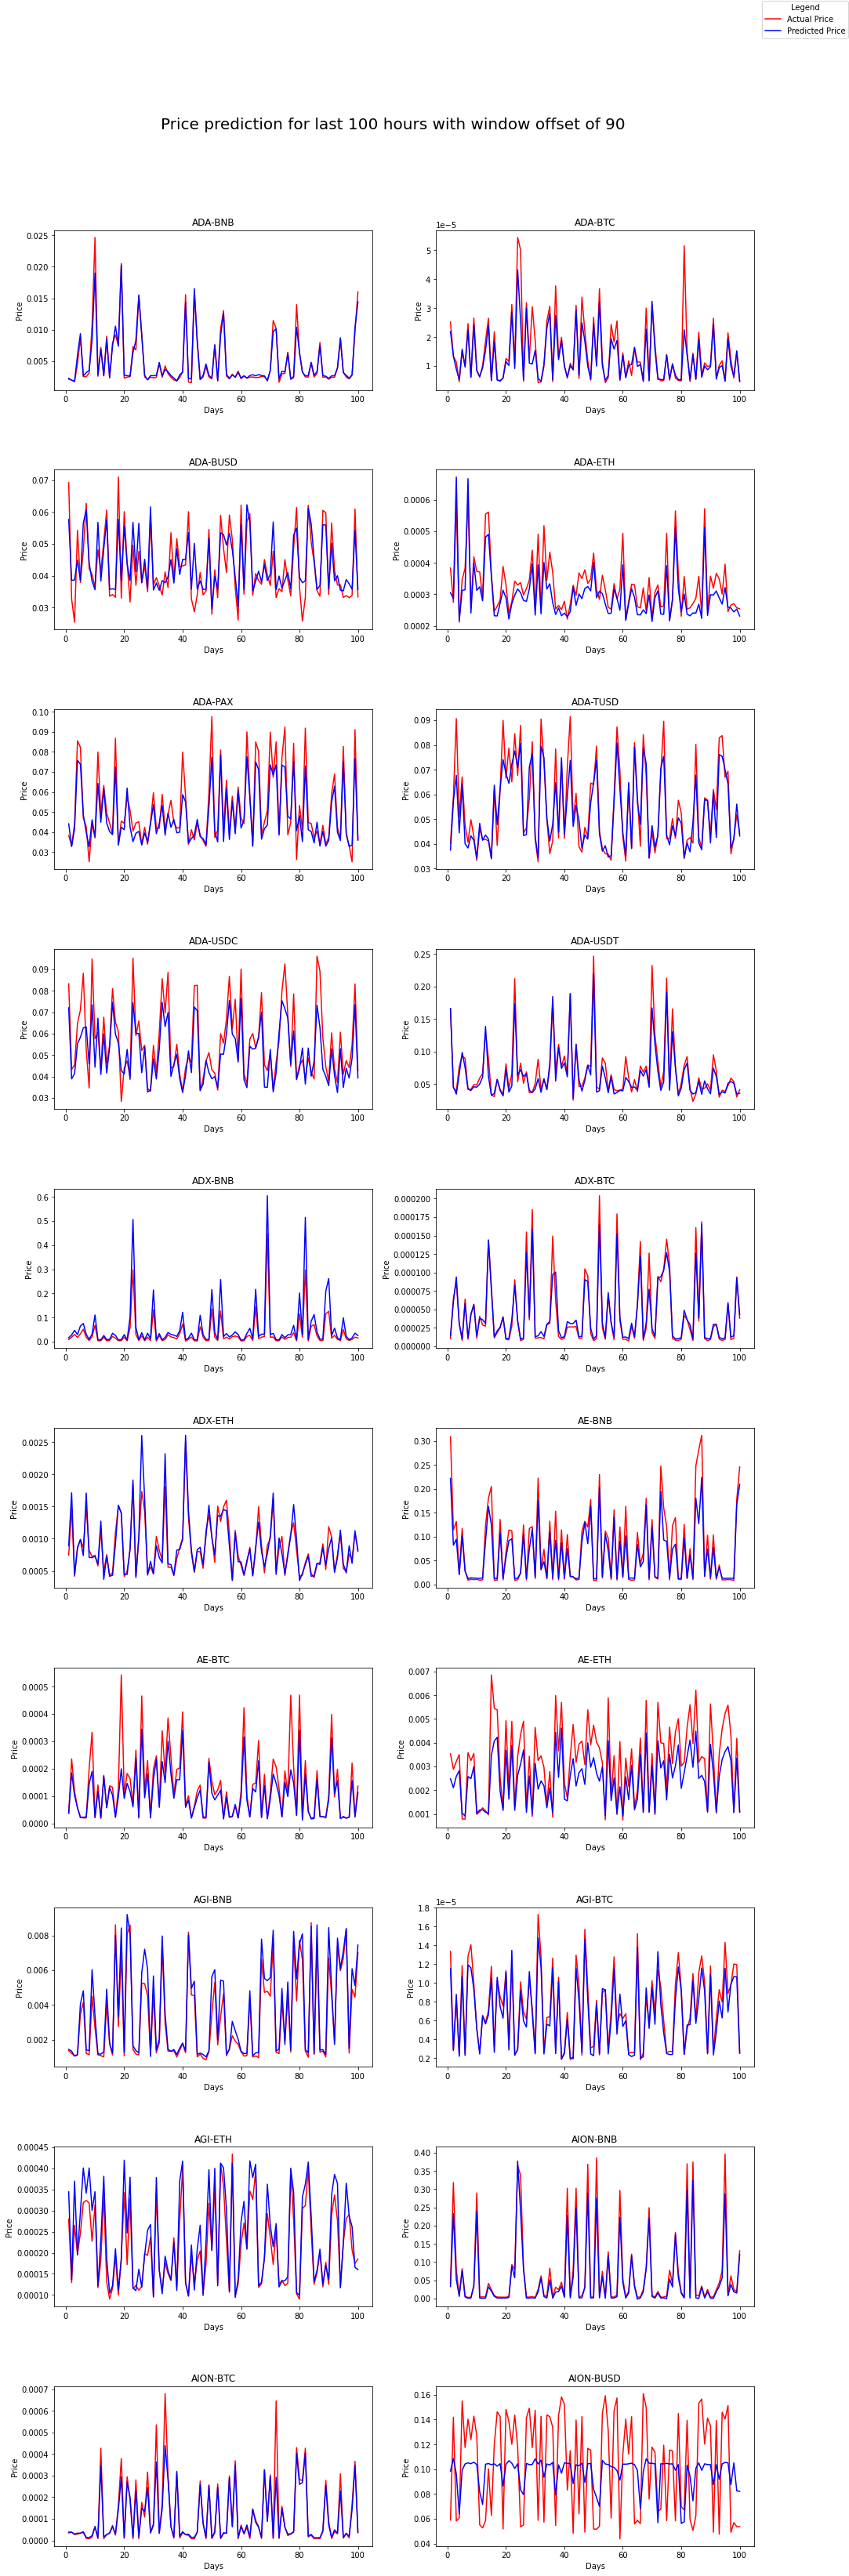

In [27]:
cu.plot_graphs(models,100,WINDOW_OFFSET)

## Read a Model from Json (Spark to ML Model)

In [107]:
from tensorflow import keras
mdl = keras.models.model_from_json(a)

In [ ]:
#cu.plot_graph(trained_model.model,data,currency,100)


#data = [('First', 1), ('Second', 2), ('Third', 3), ('Fourth', 4), ('Fifth', 5)]
#df = session.createDataFrame(data)
#df.write.csv(f"{hdp_master}/example.csv")


#session.read.json(session.sparkContext.parallelize([json_model]))
#df_model = pyspark.read.json(session.parallelize([json_model]))




#a = session.read.csv(f"{hdp_master}/Abcnews-date-text.csv")

#df_load = session.read.csv(f"{hdp_master}/example.csv")
#df_load.show()